<a href="https://colab.research.google.com/github/NaganandiniS/Practice-code/blob/master/Copy_of_Women_hackathon_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import pandas as pd
import io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [0]:
# Upload the files
from google.colab import files

In [9]:
uploaded = files.upload()

Saving train.csv to train (1).csv


In [11]:
df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
df.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,44113,1,49,Business,Course,0,1,0,12999,0.024,76
1,181755,1,200,Business,Course,0,1,1,10122,0.001,42
2,221525,1,243,Business,Course,0,1,0,36771,0.016,174
3,392733,1,431,Business,Degree,0,1,1,26208,0.011,91
4,541678,1,594,Business,Degree,0,1,0,29505,0.009,107


In [12]:
print(df.shape)
print(df.columns)

(512087, 11)
Index(['ID', 'Day_No', 'Course_ID', 'Course_Domain', 'Course_Type',
       'Short_Promotion', 'Public_Holiday', 'Long_Promotion', 'User_Traffic',
       'Competition_Metric', 'Sales'],
      dtype='object')


In [0]:
#drop unnecessary ones
df.drop(['ID'], axis=1, inplace=True)
df = df.sort_values(by=['Day_No', 'Course_ID'])

In [14]:
print(df.dtypes)
print(df.describe())
print(df.isnull().count())

Day_No                  int64
Course_ID               int64
Course_Domain          object
Course_Type            object
Short_Promotion         int64
Public_Holiday          int64
Long_Promotion          int64
User_Traffic            int64
Competition_Metric    float64
Sales                   int64
dtype: object
              Day_No      Course_ID  ...  Competition_Metric          Sales
count  512087.000000  512087.000000  ...       510323.000000  512087.000000
mean      434.917869     300.388344  ...            0.073345     120.826924
std       256.044161     173.365787  ...            0.100115      54.355258
min         1.000000       1.000000  ...            0.000000       0.000000
25%       214.000000     150.000000  ...            0.010000      84.000000
50%       427.000000     300.000000  ...            0.035000     111.000000
75%       658.000000     451.000000  ...            0.094000     146.000000
max       882.000000     600.000000  ...            0.768000     682.000000

[

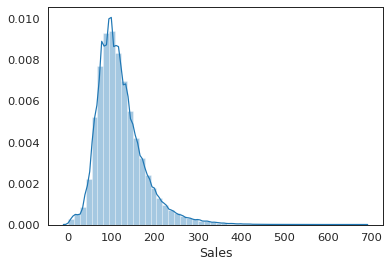

In [15]:
sns.distplot(df['Sales'])

In [16]:
ds = df.pivot_table(index='Day_No', columns='Course_ID')
print(ds.head())

          Competition_Metric                ... User_Traffic                  
Course_ID                1      2      3    ...          598      599      600
Day_No                                      ...                               
1                      0.007  0.186  0.316  ...       8505.0  14805.0  69258.0
2                      0.007  0.186  0.316  ...      18732.0  15813.0   6405.0
3                      0.007  0.186  0.316  ...      16989.0  15078.0   6300.0
4                      0.007  0.186  0.316  ...      18081.0  13566.0   6846.0
5                      0.007  0.186  0.316  ...      17976.0  11949.0   7119.0

[5 rows x 3598 columns]


In [17]:
ds.head()

Competition_Metric                ... User_Traffic                  
Course_ID                1      2      3    ...          598      599      600
Day_No                                      ...                               
1                      0.007  0.186  0.316  ...       8505.0  14805.0  69258.0
2                      0.007  0.186  0.316  ...      18732.0  15813.0   6405.0
3                      0.007  0.186  0.316  ...      16989.0  15078.0   6300.0
4                      0.007  0.186  0.316  ...      18081.0  13566.0   6846.0
5                      0.007  0.186  0.316  ...      17976.0  11949.0   7119.0

[5 rows x 3598 columns]

In [18]:
ds_t = ds.T
ds_t.head()

Day_No                          1      2      3    ...    880    881    882
                   Course_ID                       ...                     
Competition_Metric 1          0.007  0.007  0.007  ...  0.007  0.007  0.007
                   2          0.186  0.186  0.186  ...  0.186  0.186  0.186
                   3          0.316  0.316  0.316  ...  0.316  0.316  0.316
                   4          0.099  0.099  0.099  ...  0.099  0.099  0.099
                   5          0.027  0.027  0.027  ...  0.027  0.027  0.027

[5 rows x 882 columns]

In [19]:
ds_t = ds_t.sort_values(by=['Course_ID'])
ds_t.head()

,Day_No,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882
,Course_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Competition_Metric,1,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007
User_Traffic,1,11004.000,13650.000,11655.000,12054.000,6804.000,10395.000,16023.000,14385.000,16485.000,13377.000,11319.000,7077.000,11802.000,11130.000,10773.000,12411.000,8463.000,9114.000,6363.000,8547.000,13902.000,13776.000,14490.000,12222.000,10962.000,6363.000,11256.000,10248.000,9996.000,12768.000,10857.000,11634.000,7581.000,9954.000,14448.000,14154.000,16149.000,13398.000,10311.000,7434.000,...,10122.000,10122.000,9513.000,9807.000,13587.000,14238.000,15876.000,15036.000,10416.000,8883.000,10017.000,14301.000,13713.000,16380.000,12537.000,15813.000,7308.000,12768.000,11424.000,11361.000,15414.000,8211.000,12432.000,7077.000,8064.000,15687.000,13251.000,16674.000,12789.000,10584.000,6951.000,11088.000,7770.000,11844.000,14112.000,10878.000,12096.000,10773.000,10773.000,14133.000
Short_Promotion,1,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,...,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
Public_Holiday,1,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Long_Promotion,1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [20]:
ds_t1 = ds_t.T
ds_t1

Competition_Metric User_Traffic  ...  Sales User_Traffic
Course_ID                1            1    ...    600          600
Day_No                                     ...                    
1                      0.007      11004.0  ...  441.0      69258.0
2                      0.007      13650.0  ...   66.0       6405.0
3                      0.007      11655.0  ...   77.0       6300.0
4                      0.007      12054.0  ...   81.0       6846.0
5                      0.007       6804.0  ...   85.0       7119.0
...                      ...          ...  ...    ...          ...
878                    0.007      10878.0  ...  114.0       8904.0
879                    0.007      12096.0  ...  145.0      10542.0
880                    0.007      10773.0  ...  167.0      13671.0
881                    0.007      10773.0  ...  107.0       8904.0
882                    0.007      14133.0  ...  152.0      11445.0

[882 rows x 3598 columns]

In [21]:
#Overall there are 600 different courses available
df['Course_ID'].max()

600

In [22]:
#num_of_days = 800 
#train = dt[dt['Day_No'] <= num_of_days] #This will give results of 1-800 days
#test = dt[dt['Day_No'] > num_of_days] # this will give result of 801 to 882 days
#print(len(train))
#print(len(test))

NameError: ignored

In [0]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [0]:
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM

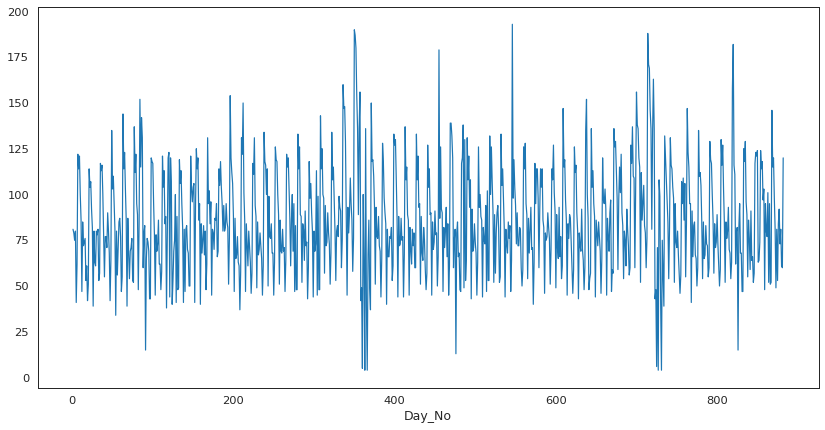

In [25]:
ds_t1['Sales'][1].plot(figsize=(14,7));

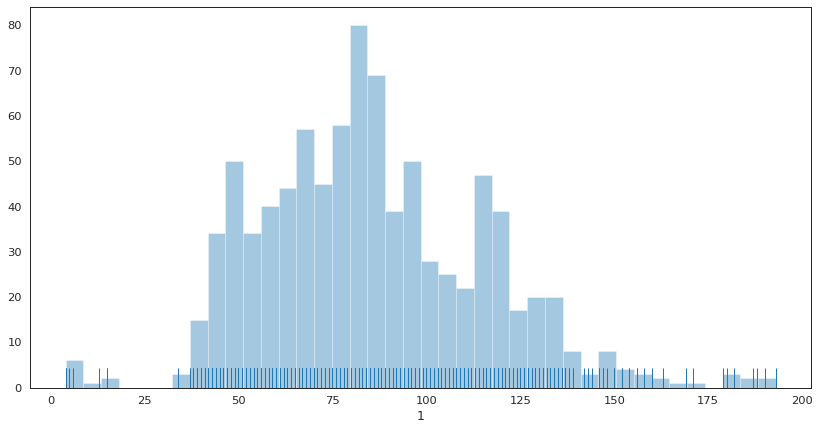

In [82]:
plt.figure(figsize=(14, 7))
sns.distplot(ds_t1['Sales'][1], bins=40, kde=False, rug=True);

In [83]:
#Copying it for easier typing
dt = ds_t1.copy()
dt.values.shape

(882, 3598)

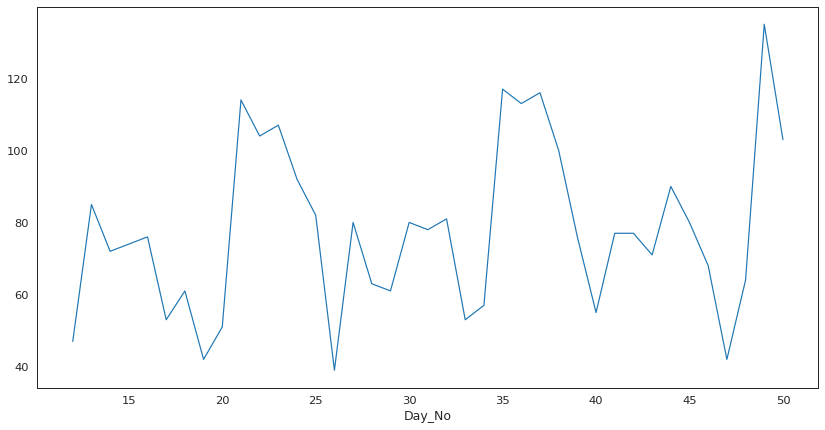

In [84]:
#Checking how the sales are for Course ID = 1 from day 11 to 50;
plt.figure(figsize=(14, 7))
dt['Sales'][1][11:50].plot();

In [0]:
#Creating Target Data
# Expected to predict for 20 days. So we need to shift the data 20 time-steps to predict the sales for 20 days into the future
tar_cid = 600 #course id - for all courses we need to predict
target_names = 'Sales'
shift_days = 1
shift_steps = shift_days * 20 #Expected to predict for 20 days

Create a new data-frame with the time-shifted data.

Note the negative time-shift!
df_targets = dt[target_names].shift(-shift_steps)

In [86]:
print(dt['Sales'][20:30])

Course_ID    1      2      3      4      5    ...    596    597    598    599    600
Day_No                                        ...                                   
21         114.0  108.0  196.0  137.0   83.0  ...  127.0  138.0  233.0  140.0   66.0
22         104.0  143.0  163.0  106.0  109.0  ...  103.0  112.0  284.0  116.0   97.0
23         107.0  141.0  138.0  116.0   88.0  ...   93.0  100.0  270.0  120.0   94.0
24          92.0  142.0  139.0  110.0   95.0  ...   78.0   98.0  253.0  118.0  101.0
25          82.0  136.0  151.0   95.0   99.0  ...   82.0   92.0  247.0  120.0   92.0
26          39.0   70.0   67.0   41.0   81.0  ...   46.0   60.0  187.0   98.0   88.0
27          80.0  111.0  133.0   94.0   80.0  ...   76.0   89.0  232.0  114.0   84.0
28          63.0   96.0  117.0   61.0   84.0  ...   68.0   87.0  165.0   89.0   64.0
29          61.0   97.0  117.0   69.0   71.0  ...   72.0   72.0  133.0   98.0   60.0
30          80.0   88.0   97.0   65.0   78.0  ...   63.0   75.0  

In [87]:
dt['Sales'][15][11:50]

Day_No
12    132.0
13    168.0
14    101.0
15    102.0
16    105.0
17    123.0
18    135.0
19    123.0
20     98.0
21    178.0
22    177.0
23    170.0
24    157.0
25    160.0
26    107.0
27    152.0
28    120.0
29    115.0
30    143.0
31    167.0
32    176.0
33    135.0
34    120.0
35    266.0
36    192.0
37    165.0
38    180.0
39    186.0
40    131.0
41    164.0
42    123.0
43    125.0
44    135.0
45    147.0
46    139.0
47    119.0
48    119.0
49    223.0
50    191.0
Name: 15, dtype: float64

In [88]:
dt['Sales'][1:30]

Course_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600
Day_No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,79.0,122.0,149.0,97.0,88.0,86.0,160.0,91.0,67.0,95.0,84.0,93.0,103.0,62.0,124.0,156.0,102.0,92.0,140.0,117.0,133.0,75.0,83.0,113.0,83.0,74.0,105.0,68.0,130.0,96.0,80.0,102.0,77.0,94.0,117.0,91.0,137.0,138.0,179.0,111.0,...,175.0,115.0,150.0,123.0,92.0,114.0,131.0,140.0,133.0,40.0,81.0,130.0,105.0,110.0,62.0,98.0,108.0,116.0,119.0,58.0,61.0,76.0,136.0,133.0,95.0,132.0,168.0,85.0,163.0,101.0,140.0,96.0,71.0,120.0,120.0,92.0,92.0,195.0,112.0,66.0
3,75.0,106.0,131.0,87.0,82.0,84.0,133.0,87.0,65.0,75.0,93.0,92.0,73.0,70.0,121.0,142.0,112.0,100.0,123.0,107.0,128.0,63.0,80.0,104.0,69.0,72.0,82.0,60.0,122.0,85.0,73.0,120.0,69.0,84.0,95.0,87.0,130.0,116.0,180.0,98.0,...,153.0,96.0,137.0,113.0,94.0,112.0,104.0,133.0,121.0,34.0,93.0,117.0,105.0,106.0,55.0,74.0,88.0,106.0,97.0,64.0,52.0,80.0,144.0,132.0,94.0,118.0,166.0,73.0,142.0,82.0,151.0,60.0,72.0,127.0,95.0,78.0,82.0,157.0,100.0,77.0
4,80.0,109.0,140.0,73.0,86.0,92.0,140.0,83.0,69.0,85.0,93.0,111.0,94.0,73.0,152.0,151.0,91.0,111.0,124.0,123.0,131.0,64.0,77.0,115.0,79.0,75.0,95.0,67.0,126.0,84.0,82.0,111.0,76.0,95.0,98.0,100.0,139.0,101.0,176.0,106.0,...,161.0,109.0,114.0,132.0,102.0,110.0,129.0,138.0,137.0,38.0,94.0,120.0,94.0,112.0,64.0,80.0,100.0,121.0,116.0,88.0,56.0,90.0,154.0,123.0,99.0,126.0,153.0,74.0,164.0,95.0,146.0,88.0,66.0,116.0,108.0,71.0,83.0,177.0,99.0,81.0
5,41.0,80.0,94.0,41.0,76.0,76.0,103.0,115.0,77.0,44.0,100.0,66.0,67.0,47.0,126.0,143.0,101.0,100.0,139.0,128.0,160.0,43.0,99.0,93.0,65.0,60.0,107.0,79.0,130.0,59.0,64.0,115.0,80.0,42.0,60.0,114.0,138.0,122.0,139.0,108.0,...,153.0,109.0,87.0,100.0,100.0,103.0,80.0,109.0,139.0,44.0,122.0,141.0,113.0,96.0,60.0,88.0,73.0,71.0,76.0,83.0,44.0,76.0,117.0,104.0,97.0,100.0,108.0,49.0,180.0,40.0,124.0,100.0,42.0,98.0,100.0,46.0,59.0,171.0,94.0,85.0
6,62.0,95.0,116.0,60.0,76.0,78.0,120.0,82.0,62.0,63.0,86.0,80.0,67.0,55.0,120.0,139.0,94.0,95.0,119.0,111.0,125.0,54.0,76.0,96.0,64.0,64.0,87.0,61.0,120.0,73.0,65.0,104.0,69.0,70.0,82.0,85.0,130.0,109.0,162.0,100.0,...,150.0,100.0,102.0,104.0,88.0,103.0,95.0,122.0,125.0,32.0,86.0,115.0,98.0,100.0,56.0,76.0,79.0,93.0,86.0,58.0,45.0,72.0,126.0,114.0,91.0,109.0,137.0,62.0,153.0,67.0,131.0,77.0,56.0,149.0,95.0,60.0,73.0,164.0,94.0,71.0
7,122.0,221.0,229.0,133.0,136.0,140.0,180.0,199.0,149.0,140.0,163.0,141.0,162.0,117.0,243.0,282.0,165.0,141.0,212.0,263.0,140.0,165.0,121.0,220.0,177.0,120.0,158.0,114.0,180.0,151.0,129.0,161.0,152.0,158.0,177.0,151.0,195.0,124.0,240.0,181.0,...,184.0,160.0,173.0,250.0,166.0,171.0,216.0,274.0,200.0,65.0,140.0,208.0,146.0,188.0,117.0,122.0,152.0,186.0,185.0,116.0,88.0,140.0,240.0,196.0,140.0,215.0,294.0,142.0,254.0,185.0,185.0,112.0,119.0,152.0,182.0,133.0,171.0,456.0,162.0,124.0
8,114.0,177.0,181.0,114.0,112.0,97.0,170.0,164.0,120.0,124.0,134.0,120.0,133.0,104.0,187.0,209.0,157.0,117.0,155.0,208.0,129.0,99.0,99.0,155.0,111.0,98.0,132.0,85.0,148.0,100.0,112.0,153.0,120.0,113.0,152.0,115.0,158.0,115.0,211.0,135.0,...,181.0,140.0,137.0,207.0,146.0,126.0,147.0,200.0,180.0,46.0,108.0,170.0,111.0,164.0,81.0,90.0,140.0,146.0,135.0,86.0,66.0,115.0,226.0,157.0,122.0,165.0,242.0,107.0,187.0,140.0,170.0,79.0,101.0,145.0,154.0,112.0,116.0,308.0,123.0,95.0
9,121.0,144.0,127.0,91.0,84.0,102.0,152.0,150.0,95.0,97.0,122.0,118.0,111.0,95.0,171.0,177.0,102.0,114.0,148.0,181.0,121.0,75.0,80.0,142.0,114.0,79.0,118.0,64.0,136.0,95.0,116.0,125.0,97.0,126.0,113.0,114.0,146.0,110.0,185.0,122.0,...,156.0,130.0,119.0,193.0,132.0,121.0,132.0,181.0,150.0,59.0,114.0,150.0,103.0,141.0,75.0,91.0,100.0,115.0,114.0,102.0,57.0,100.0,189.0,133.0,113.0,158.0,200.0,97.0,186.0,149.0,152.0,81.0,100.0,157.0,143.0,93.0,95.0,26

In [89]:
array_sum = np.sum(dt)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

                    Course_ID
Competition_Metric  1            False
User_Traffic        1            False
Short_Promotion     1            False
Public_Holiday      1            False
Long_Promotion      1            False
                                 ...  
Public_Holiday      600          False
Long_Promotion      600          False
Competition_Metric  600          False
Sales               600          False
User_Traffic        600          False
Length: 3598, dtype: bool


In [90]:
df_targets = dt[target_names].shift(-shift_steps) #21st record has moved to 1st place/index and the tail is showing NAN
df_targets

Course_ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600
Day_No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,114.0,108.0,196.0,137.0,83.0,112.0,161.0,202.0,115.0,123.0,143.0,115.0,120.0,91.0,178.0,152.0,137.0,123.0,182.0,133.0,114.0,133.0,100.0,155.0,133.0,100.0,160.0,65.0,152.0,111.0,108.0,101.0,131.0,134.0,149.0,141.0,156.0,110.0,160.0,131.0,...,160.0,160.0,125.0,147.0,153.0,98.0,160.0,207.0,186.0,66.0,137.0,179.0,120.0,133.0,113.0,107.0,135.0,158.0,110.0,107.0,66.0,116.0,129.0,148.0,114.0,165.0,164.0,123.0,215.0,151.0,148.0,79.0,100.0,166.0,160.0,127.0,138.0,233.0,140.0,66.0
2,104.0,143.0,163.0,106.0,109.0,94.0,145.0,151.0,119.0,120.0,124.0,104.0,126.0,92.0,177.0,189.0,137.0,103.0,152.0,160.0,125.0,94.0,93.0,164.0,118.0,77.0,131.0,75.0,164.0,99.0,118.0,124.0,119.0,125.0,138.0,111.0,159.0,108.0,188.0,120.0,...,187.0,137.0,130.0,159.0,133.0,132.0,156.0,150.0,157.0,56.0,100.0,146.0,117.0,137.0,78.0,107.0,106.0,135.0,136.0,88.0,67.0,115.0,187.0,152.0,115.0,149.0,222.0,119.0,201.0,133.0,145.0,91.0,106.0,175.0,155.0,103.0,112.0,284.0,116.0,97.0
3,107.0,141.0,138.0,116.0,88.0,94.0,151.0,151.0,101.0,102.0,115.0,112.0,121.0,81.0,170.0,189.0,104.0,90.0,141.0,172.0,128.0,87.0,94.0,142.0,105.0,76.0,120.0,85.0,150.0,96.0,98.0,131.0,100.0,114.0,130.0,106.0,163.0,110.0,198.0,119.0,...,174.0,114.0,120.0,159.0,118.0,133.0,133.0,181.0,144.0,50.0,98.0,140.0,98.0,142.0,80.0,93.0,111.0,136.0,120.0,89.0,46.0,100.0,189.0,119.0,104.0,151.0,203.0,96.0,184.0,121.0,151.0,85.0,88.0,165.0,136.0,93.0,100.0,270.0,120.0,94.0
4,92.0,142.0,139.0,110.0,95.0,85.0,128.0,139.0,97.0,108.0,110.0,109.0,105.0,75.0,157.0,180.0,142.0,99.0,133.0,182.0,131.0,78.0,90.0,135.0,103.0,74.0,115.0,89.0,150.0,93.0,88.0,142.0,104.0,89.0,120.0,114.0,160.0,92.0,191.0,106.0,...,154.0,115.0,125.0,137.0,104.0,143.0,126.0,160.0,144.0,45.0,112.0,141.0,109.0,132.0,72.0,104.0,114.0,120.0,114.0,93.0,49.0,102.0,175.0,128.0,112.0,152.0,203.0,101.0,165.0,114.0,134.0,81.0,80.0,171.0,114.0,78.0,98.0,253.0,118.0,101.0
5,82.0,136.0,151.0,95.0,99.0,97.0,140.0,140.0,98.0,103.0,122.0,121.0,126.0,98.0,160.0,178.0,97.0,105.0,148.0,179.0,153.0,69.0,84.0,152.0,111.0,88.0,124.0,83.0,146.0,100.0,96.0,153.0,109.0,98.0,117.0,132.0,169.0,100.0,189.0,127.0,...,174.0,120.0,120.0,157.0,115.0,136.0,134.0,148.0,171.0,60.0,111.0,151.0,106.0,132.0,76.0,99.0,107.0,134.0,108.0,100.0,46.0,103.0,183.0,121.0,103.0,155.0,198.0,87.0,192.0,106.0,155.0,80.0,77.0,171.0,138.0,82.0,92.0,247.0,120.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [91]:
array_sum = np.sum(df_targets)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

Course_ID
1      False
2      False
3      False
4      False
5      False
       ...  
596    False
597    False
598    False
599    False
600    False
Length: 600, dtype: bool


In [92]:
#These are the input-signals:
x_data = dt.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (862, 3598)


In [93]:
array_sum = np.sum(x_data)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

True


In [0]:
x_data = np.nan_to_num(x_data) 

In [95]:
array_sum = np.sum(x_data)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [96]:
#These are the output-signals (or target-signals):
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (862, 600)


In [97]:
#This is the number of observations (aka. data-points or samples) in the data-set:
num_data = len(x_data)
num_data

862

In [0]:
#This is the fraction of the data-set that will be used for the training-set:
train_split = 0.9

In [99]:
#This is the number of observations in the training-set:
num_train = int(train_split * num_data)
num_train

775

In [100]:
#This is the number of observations in the test-set:
num_test = num_data - num_train
num_test

87

In [101]:
#These are the input-signals for the training- and test-sets:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

862

In [102]:
#These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

862

In [103]:
#This is the number of input-signals:
num_x_signals = x_data.shape[1]
num_x_signals

3598

In [104]:
#This is the number of output-signals:
num_y_signals = y_data.shape[1]
num_y_signals

600

**SCALING THE DATA**

In [105]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 100002.0


In [106]:
x_train

array([[7.0000e-03, 1.1004e+04, 0.0000e+00, ..., 7.0000e-02, 4.4100e+02,
        6.9258e+04],
       [7.0000e-03, 1.3650e+04, 0.0000e+00, ..., 7.0000e-02, 6.6000e+01,
        6.4050e+03],
       [7.0000e-03, 1.1655e+04, 0.0000e+00, ..., 7.0000e-02, 7.7000e+01,
        6.3000e+03],
       ...,
       [7.0000e-03, 1.0185e+04, 0.0000e+00, ..., 7.0000e-02, 8.7000e+01,
        7.7070e+03],
       [7.0000e-03, 1.0479e+04, 0.0000e+00, ..., 7.0000e-02, 1.0500e+02,
        9.5340e+03],
       [7.0000e-03, 7.3710e+03, 0.0000e+00, ..., 7.0000e-02, 1.2800e+02,
        1.0563e+04]])

In [107]:
array_sum = np.sum(x_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [0]:
x_train = np.nan_to_num(x_train)

In [109]:
array_sum = np.sum(x_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [110]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.0
Max: 100002.0


In [0]:
#We first create a scaler-object for the input-signals.
x_scaler = MinMaxScaler()

In [0]:
#We then detect the range of values from the training-data and scale the training-data.
x_train_scaled = x_scaler.fit_transform(x_train)

In [113]:
#Ignore the rounding error of 2 in the end
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [0]:
#We use the same scaler-object for the input-signals in the test-set.
x_test = np.nan_to_num(x_test)
y_train = np.nan_to_num(y_train)
y_test = np.nan_to_num(y_train)

x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

**Data Generator**

In [115]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(775, 3598)
(775, 600)


In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            #num_train itself is 775 so, cannot take sequence length beyond 600... as it may break the data
            idx = np.random.randint(num_train - sequence_length) 
                        
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [0]:
# batch size can be between 50 to 256 only. Let me go for max GPU
batch_size = 256
# sequence length... approximately taking 1800
sequence_length = 600 * 1 

In [0]:
#We then create the batch-generator.
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)
#We can then test the batch-generator to see if it works.
x_batch, y_batch = next(generator)

In [119]:
print(x_batch.shape)
print(y_batch.shape)

(256, 600, 3598)
(256, 600, 600)


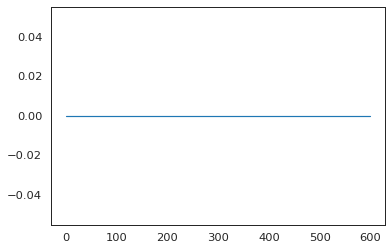

In [120]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

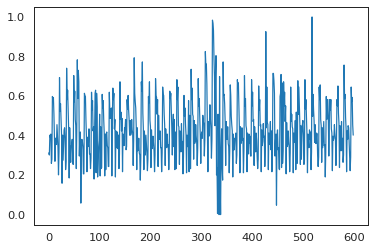

In [121]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [0]:
model = Sequential()

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))

In [0]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)
    
    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [0]:
warmup_steps = 50

In [0]:
def loss_msle_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    #msle = tf.keras.losses.MSLE(y_true_slice, y_pred_slice)
    #msle = square(log(y_true_slice) - log(y_pred_slice))
    
    return mse

In [0]:
optimizer = RMSprop(lr=1e-3)

In [0]:
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=optimizer)

In [131]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         6316032   
_________________________________________________________________
dense_1 (Dense)              (None, None, 600)         307800    
Total params: 6,623,832
Trainable params: 6,623,832
Non-trainable params: 0
_________________________________________________________________


**Callback Functions**

In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [0]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

**Train the Recurrent Neural Network**

In [138]:
%%time
#EMBEDDING_DIM = 32
#Bidirectional(LSTM(32, return_sequences=False))(embedding)
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20


InternalError: ignored

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)